<a href="https://colab.research.google.com/github/MartinHou/DL/blob/main/bottle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dir = '/content/gdrive/MyDrive/datasets/bottles'

In [ ]:
classes = os.listdir(dir)
classes

['HDPEM', 'AluCan', 'PET', 'Glass']

In [ ]:
transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

In [ ]:
def ReturnImage(img):
  a = img.detach()
  a[0,:,:]=a[0,:,:]*0.229+0.485
  a[1,:,:]=a[1,:,:]*0.224+0.456
  a[2,:,:]=a[2,:,:]*0.225+0.406
  return a

In [ ]:
dataset = ImageFolder(dir,transform=transforms)
dataset

Dataset ImageFolder
    Number of datapoints: 4860
    Root location: /content/gdrive/MyDrive/datasets/bottles
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
n_total = len(dataset)
n_total

4860

In [ ]:
def show_samples(img,label):
  print(f'Label:{dataset.classes[label]}(Class No.{label})')
  plt.imshow(img.permute(1,2,0))

In [ ]:
img,label = dataset[12]
img.size()

torch.Size([3, 256, 256])

Label:AluCan(Class No.0)


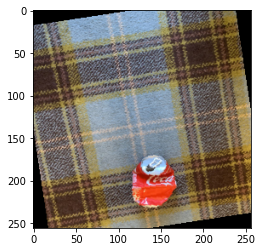

In [ ]:
img,label = dataset[12]
img = ReturnImage(img)
show_samples(img,label)

Label:HDPEM(Class No.2)


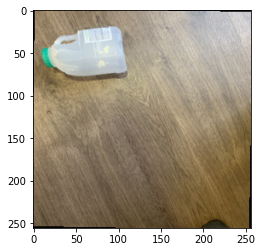

In [ ]:
img,label = dataset[2322]
img = ReturnImage(img)
show_samples(img,label)

## 加载数据和划分数据集

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
n_train = int(n_total * 0.6)
n_val = int(n_total * 0.2)
n_test = n_total - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset,[n_train,n_val,n_test])
len(train_ds),len(val_ds),len(test_ds)

(2916, 972, 972)

In [ ]:
b_size = 32

In [ ]:
train_dl = DataLoader(train_ds,b_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_ds,b_size*2,num_workers=2,pin_memory=True)

# 可视化batch

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for img,label in dl:
    for i in range(len(img)):
      img[i] = ReturnImage(img[i])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(img, nrow = 16).permute(1, 2, 0)) # makegrid用于拼接图片
    break

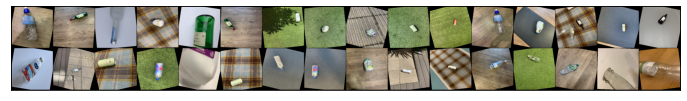

In [ ]:
show_batch(train_dl)

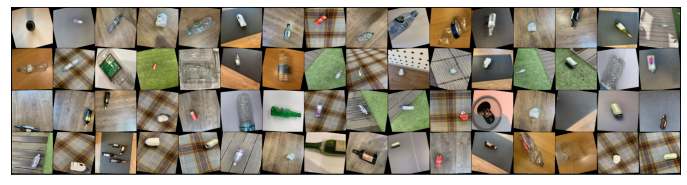

In [ ]:
show_batch(val_dl)

# 建模

In [ ]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
    
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

# 将数据转移到GPU上

In [ ]:
def get_default_device():
    
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# 训练

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.3212890625, 'val_loss': 1.3721143007278442}

In [ ]:
num_epochs = 12
opt_func = torch.optim.Adam
lr = 0.00003

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.0346, val_loss: 0.8221, val_acc: 0.9766
Epoch 2: train_loss: 0.7967, val_loss: 0.7708, val_acc: 0.9883
Epoch 3: train_loss: 0.7714, val_loss: 0.7646, val_acc: 0.9902
Epoch 4: train_loss: 0.7636, val_loss: 0.7585, val_acc: 0.9951
Epoch 5: train_loss: 0.7596, val_loss: 0.7553, val_acc: 0.9932
Epoch 6: train_loss: 0.7543, val_loss: 0.7560, val_acc: 0.9922
Epoch 7: train_loss: 0.7508, val_loss: 0.7534, val_acc: 0.9912
Epoch 8: train_loss: 0.7536, val_loss: 0.7516, val_acc: 0.9941
Epoch 9: train_loss: 0.7526, val_loss: 0.7529, val_acc: 0.9922
Epoch 10: train_loss: 0.7510, val_loss: 0.7518, val_acc: 0.9912
Epoch 11: train_loss: 0.7515, val_loss: 0.7513, val_acc: 0.9961
Epoch 12: train_loss: 0.7529, val_loss: 0.7505, val_acc: 0.9951


# 绘图

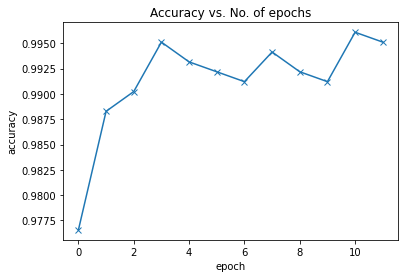

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

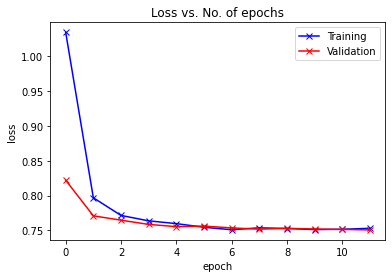

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# 预测可视化

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: PET , Predicted: PET


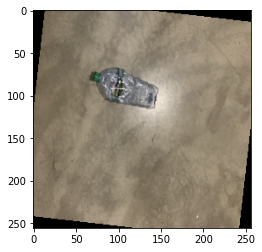

In [ ]:
img, label = test_ds[17]
img = ReturnImage(img)
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Glass , Predicted: Glass


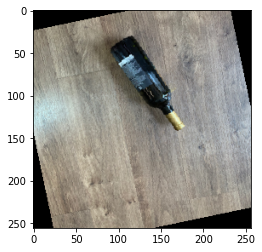

In [ ]:
img, label = test_ds[23]
img = ReturnImage(img)
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# 存模型

In [ ]:
PATH = './gdrive/MyDrive/datasets/bottles/model'
torch.save(model.state_dict(), PATH)